In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time

import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL
import cv2 as cv

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from tqdm import tqdm_notebook, tqdm

![image](https://github.com/Lexie88rus/Bengali_AI_Competition/raw/master/assets/samples.png)

# Bengali.AI EfficientNet Starter Notebook

Bengali.AI is a wonderful competition, especially for the beginners in deep learning. I created this simple pytorch notebook to demonstrate some code for Bengali hadwrittem symbols classification.

I tried to add some data visualization tips throughout this notebook, which help to check the inputs and outputs of the model.

Unfortunately, this code can't be used to make submissions for this competition on Kaggle, but it still can serve as a starting point to develop your own models for Bengali handwriting classification.

## Load Data

Specify the path to data and load the csv files:

In [5]:
# setup the input data folder
DATA_PATH = '../input/bengaliai-cv19/'

# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

Load the test and train sets:

In [6]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet(DATA_PATH + 'train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet(DATA_PATH + 'test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test

In [7]:
train, test = load_images()

## Image Preprocessing and Data Augmentation

Preprocessing and data augmentation are exteremely important for the training of deep learning models. I use the adaptive thresholding to binarize the input images and a simple data augmentation pipeline consisting of random crop-resize and slight rotation of the input images.

In [72]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236

SIZE = 32

def threshold_image(img):
    '''
    Helper function for thresholding the images
    '''
    gray = PIL.Image.fromarray(np.uint8(img), 'L')
    ret,th = cv.threshold(np.array(gray),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def train_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.CenterCrop(height = 128, width = 128),
        #albu.Rotate(limit=5, p=p),
        albu.Resize(height = SIZE, width = SIZE)
    ], p=1.0)

def valid_transforms():
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.CenterCrop(height = 128, width = 128),
        albu.Resize(height = SIZE, width = SIZE)
    ], p=1.0)

## Define the Dataset

The next step is to create a custom pytorch dataset, which will produce images and corresponding labels out of the traing dataset:

In [73]:
'''
Helper functions to retrieve the images from the dataset in training and validation modes
'''

def get_image(idx, df, labels):
    '''
    Helper function to get the image and label from the training set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    # get the labels
    row = labels[labels.image_id == image_id]
    
    # return labels as tuple
    labels = row['grapheme_root'].values[0], \
    row['vowel_diacritic'].values[0], \
    row['consonant_diacritic'].values[0]
    
    return img, labels

def get_validation(idx, df):
    '''
    Helper function to get the validation image and image_id from the test set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    return img, image_id

In [74]:
class BengaliDataset(Dataset):
    '''
    Create a custom Bengali images dataset
    '''
    def __init__(self, df_images, transforms, df_labels = None, validation = False):
        '''
        Init function
        INPUT:
            df_images - dataframe with the images
            transforms - data transforms
            df_labels - datafrane containing the target labels
            validation - flag indication if the dataset is for training or for validation
        '''
        self.df_images = df_images
        self.df_labels = df_labels
        self.transforms = transforms
        self.validation = validation

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        if not self.validation:
            # get the image
            img, label = get_image(idx, self.df_images, self.df_labels)
            # threshold the image
            img = threshold_image(img)
            # transform the image
            #img = img.astype(np.uint8)
            aug = self.transforms(image = img)
            return TF.to_tensor(aug['image']), label
        else:
            # get the image
            img, image_id = get_validation(idx, self.df_images)
            # threshold the image
            img = threshold_image(img)
            # transform the image
            #img = img.astype(np.uint8)
            aug = self.transforms(image = img)
            # return transformed image and corresponding image_id (instead of label) to create submission
            return TF.to_tensor(aug['image']), image_id

Now let's check that everything is correct. Let's try to retrieve couple of images from the dataset:

In [75]:
# initialize train dataset
train_dataset = BengaliDataset(train, train_transforms(), train_labels)
# create a sample trainloader
sample_trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)

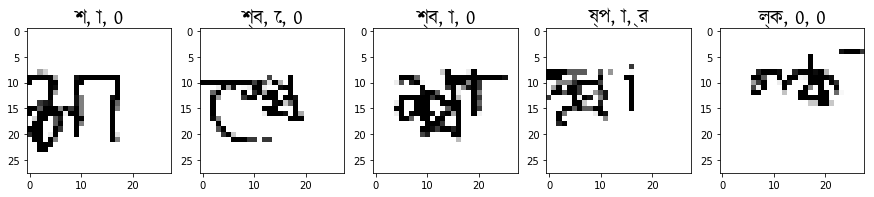

In [76]:
# plot sample train data
for img, labels in sample_trainloader:
    
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
        grapheme_root = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[i].set_title('{}, {}, {}'.format(grapheme_root, vowel_diacritic, consonant_diacritic), 
                         fontproperties=prop, fontsize=20)
    break;

## Define the Model

In [13]:
# implement mish activation function
def f_mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    '''
    return input * torch.tanh(F.softplus(input))

# implement class wrapper for mish activation function
class mish(nn.Module):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = mish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_mish(input)

In [14]:
# implement swish activation function
def f_swish(input):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)
    '''
    return input * torch.sigmoid(input)

# implement class wrapper for swish activation function
class swish(nn.Module):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = swish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_swish(input)

In [15]:
class LinearBottleNeck(nn.Module):

    def __init__(self, in_channels, out_channels, stride, t=6, class_num=10, activation = 'relu'):
        super().__init__()
        
        if activation == 'relu':
            f_activation = nn.ReLU6(inplace=True)
            
        if activation == 'swish':
            f_activation = swish()
            
        if activation == 'mish':
            f_activation = mish()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, 1),
            nn.BatchNorm2d(in_channels * t),
            f_activation,

            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            f_activation,

            nn.Conv2d(in_channels * t, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
    
    def forward(self, x):

        residual = self.residual(x)

        if self.stride == 1 and self.in_channels == self.out_channels:
            residual += x
        
        return residual
    
class MobileNetV2(nn.Module):

    def __init__(self, class_num=10, activation = 'relu'):
        super().__init__()
        
        if activation == 'relu':
            f_activation = nn.ReLU6(inplace=True)
            
        if activation == 'swish':
            f_activation = swish()
            
        if activation == 'mish':
            f_activation = mish()

        self.pre = nn.Sequential(
            nn.Conv2d(1, 32, 1, padding=1),
            nn.BatchNorm2d(32),
            f_activation
        )

        self.stage1 = LinearBottleNeck(32, 16, 1, 1, activation = activation)
        self.stage2 = self._make_stage(2, 16, 24, 2, 6, activation = activation)
        self.stage3 = self._make_stage(3, 24, 32, 2, 6, activation = activation)
        self.stage4 = self._make_stage(4, 32, 64, 2, 6, activation = activation)
        self.stage5 = self._make_stage(3, 64, 96, 1, 6, activation = activation)
        self.stage6 = self._make_stage(3, 96, 160, 1, 6, activation = activation)
        self.stage7 = LinearBottleNeck(160, 320, 1, 6, activation = activation)

        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            f_activation
        )

        self.conv2 = nn.Conv2d(1280, class_num, 1)
        
    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        return x
    
    def _make_stage(self, repeat, in_channels, out_channels, stride, t, activation = 'relu'):

        layers = []
        layers.append(LinearBottleNeck(in_channels, out_channels, stride, t, activation = activation))
        
        while repeat - 1:
            layers.append(LinearBottleNeck(out_channels, out_channels, 1, t, activation = activation))
            repeat -= 1
        
        return nn.Sequential(*layers)

def mobilenetv2(activation = 'relu'):
    return MobileNetV2(class_num = 1000, activation = activation)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def channel_split(x, split):
    """split a tensor into two pieces along channel dimension
    Args:
        x: input tensor
        split:(int) channel size for each pieces
    """
    assert x.size(1) == split * 2
    return torch.split(x, split, dim=1)
    
def channel_shuffle(x, groups):
    """channel shuffle operation
    Args:
        x: input tensor
        groups: input branch number
    """

    batch_size, channels, height, width = x.size()
    channels_per_group = int(channels / groups)

    x = x.view(batch_size, groups, channels_per_group, height, width)
    x = x.transpose(1, 2).contiguous()
    x = x.view(batch_size, -1, height, width)

    return x

class ShuffleUnit(nn.Module):

    def __init__(self, in_channels, out_channels, stride):
        super().__init__()

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        if stride != 1 or in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 1),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, int(out_channels / 2), 1),
                nn.BatchNorm2d(int(out_channels / 2)),
                nn.ReLU(inplace=True)
            )

            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, int(out_channels / 2), 1),
                nn.BatchNorm2d(int(out_channels / 2)),
                nn.ReLU(inplace=True)
            )
        else:
            self.shortcut = nn.Sequential()

            in_channels = int(in_channels / 2)
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 1),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, in_channels, 1),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True) 
            )

    
    def forward(self, x):

        if self.stride == 1 and self.out_channels == self.in_channels:
            shortcut, residual = channel_split(x, int(self.in_channels / 2))
        else:
            shortcut = x
            residual = x
        
        shortcut = self.shortcut(shortcut)
        residual = self.residual(residual)
        x = torch.cat([shortcut, residual], dim=1)
        x = channel_shuffle(x, 2)
        
        return x

class ShuffleNetV2(nn.Module):

    def __init__(self, ratio=0.5, class_num=1000):
        super().__init__()
        if ratio == 0.5:
            out_channels = [48, 96, 192, 1024]
        elif ratio == 1:
            out_channels = [116, 232, 464, 1024]
        elif ratio == 1.5:
            out_channels = [176, 352, 704, 1024]
        elif ratio == 2:
            out_channels = [244, 488, 976, 2048]
        else:
            ValueError('unsupported ratio number')
        
        self.pre = nn.Sequential(
            nn.Conv2d(1, 24, 3, padding=1),
            nn.BatchNorm2d(24)
        )

        self.stage2 = self._make_stage(24, out_channels[0], 3)
        self.stage3 = self._make_stage(out_channels[0], out_channels[1], 7)
        self.stage4 = self._make_stage(out_channels[1], out_channels[2], 3)
        self.conv5 = nn.Sequential(
            nn.Conv2d(out_channels[2], out_channels[3], 1),
            nn.BatchNorm2d(out_channels[3]),
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Linear(out_channels[3], class_num)

    def forward(self, x):
        x = self.pre(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def _make_stage(self, in_channels, out_channels, repeat):
        layers = []
        layers.append(ShuffleUnit(in_channels, out_channels, 2))

        while repeat:
            layers.append(ShuffleUnit(out_channels, out_channels, 1))
            repeat -= 1
        
        return nn.Sequential(*layers)

def shufflenetv2():
    return ShuffleNetV2()

In [56]:
backbone_model = shufflenetv2()

In [57]:
'''
Custom model for the Bengali images
backbone model may be replaced with any other archirtecture :)
'''

class BengaliModel(nn.Module):
    def __init__(self, backbone_model):
        super(BengaliModel, self).__init__()
        #self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
        self.backbone_model = backbone_model
        self.fc1 = nn.Linear(in_features=1000, out_features=168) # grapheme_root
        self.fc2 = nn.Linear(in_features=1000, out_features=11) # vowel_diacritic
        self.fc3 = nn.Linear(in_features=1000, out_features=7) # consonant_diacritic
        
    def forward(self, x):
        # pass through the backbone model
        #y = self.conv(x)
        y = self.backbone_model(x)
        
        # multi-output
        grapheme_root = self.fc1(y)
        vowel_diacritic = self.fc2(y)
        consonant_diacritic = self.fc3(y)
        
        return grapheme_root, vowel_diacritic, consonant_diacritic

In [58]:
# initialize the final model
model = BengaliModel(backbone_model)

## Train the Model

Now we are all set for the modelling:

First, let's start with defining the hyperparameters. In this notebook I won't be actually training the model, that is why the number of epochs is 0. I trained the model on my own machine and will just load the weights here.

In [59]:
test_split = 0.2
batch_size = 64
epochs = 1 # change this value to actually train the model
learning_rate = 0.001
num_workers = 0

Setup the dataset and samplers:

In [60]:
dataset_size = len(train_dataset)

# split the dataset into test and train
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = DataLoader(train_dataset, batch_size=32, sampler=test_sampler, num_workers=num_workers)

Optimizer and loss function:

In [61]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

Define a training device:

In [62]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Setup the logging. I will write the log into pandas DataFrame.

In [63]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy'
                                      ,'Test loss', 'Test accuracy'])

Now we are ready to train! 

In [64]:
# move the model to the training device
model = model.to(device)

In [65]:
# I'm just loading the weights instead of training
#state = torch.load('../input/bengaliaiutils/efficientnet_b0_10.pth', map_location=lambda storage, loc: storage)
#model.load_state_dict(state["state_dict"])

Training loop:

In [66]:
def get_accuracy(ps, labels):
    '''
    Helper function to calculate the accuracy given the labels and the output of the model
    '''
    ps = torch.exp(ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    return accuracy

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in tqdm(trainloader):
        steps += 1
        # move input and label tensors to the default device
        inputs, labels = inputs.to(device), [label.to(device) for label in labels]
        
        optimizer.zero_grad()
        
        # forward pass
        grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
        
        # calculate the loss
        loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + \
        criterion(consonant_diacritic, labels[2])
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # get the average accuracy
        train_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0

        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    model.eval()
    # run validation on the test set
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), [label.to(device) for label in labels]
            
            grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
            batch_loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + criterion(consonant_diacritic, labels[2])
        
            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            test_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0
    
    # print out the training stats
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")

    # write to the training log
    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader),
                                      'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader),
                                      'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0
    steps = 0
    model.train()







  0%|          | 0/2511 [00:00<?, ?it/s]





  0%|          | 1/2511 [00:06<4:25:55,  6.36s/it]





  0%|          | 2/2511 [00:12<4:22:02,  6.27s/it]





  0%|          | 3/2511 [00:18<4:19:45,  6.21s/it]





  0%|          | 4/2511 [00:24<4:16:02,  6.13s/it]





  0%|          | 5/2511 [00:30<4:15:35,  6.12s/it]





  0%|          | 6/2511 [00:36<4:12:56,  6.06s/it]





  0%|          | 7/2511 [00:42<4:13:45,  6.08s/it]





  0%|          | 8/2511 [00:49<4:20:07,  6.24s/it]





  0%|          | 9/2511 [00:55<4:20:00,  6.24s/it]





  0%|          | 10/2511 [01:01<4:18:03,  6.19s/it]





  0%|          | 11/2511 [01:07<4:14:10,  6.10s/it]





  0%|          | 12/2511 [01:13<4:13:17,  6.08s/it]





  1%|          | 13/2511 [01:19<4:13:20,  6.09s/it]





  1%|          | 14/2511 [01:25<4:12:33,  6.07s/it]

KeyboardInterrupt: 

## Analyze Results

Now we can look at the training results:

In [ ]:
# I load my training stats from the local machine :)
train_stats = pd.read_csv('../input/bengaliaiutils/efficientnet_b0_train_stats_10.csv')

In [ ]:
# plot the loss
plt.plot(train_stats['Train loss'], label='train')
plt.plot(train_stats['Test loss'], label='test')
plt.title('Loss over epoch')
plt.legend()
plt.show()

In [ ]:
# plot the accuracy
plt.plot(train_stats['Train accuracy'], label='train')
plt.plot(train_stats['Test accuracy'], label='test')
plt.title('Accuracy over epoch')
plt.legend()
plt.show()

Let's also visualize some sample predictions from the train set:

In [ ]:
# plot sample train data
model.eval()
for img, labels in testloader:
    img, labels = img.to(device), [label.to(device) for label in labels]
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(img)
    
    img = img.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    # visualize the inputs
    fig, axs = plt.subplots(4, 1, figsize=(10,15))
    for i in range(0, img.shape[0]):
        axs[0].imshow(TF.to_pil_image(img[i].reshape(HEIGHT, WIDTH)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
        grapheme_root_str = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic_str = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic_str = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[0].set_title('{}, {}, {}'.format(grapheme_root_str, vowel_diacritic_str, consonant_diacritic_str), 
                         fontproperties=prop, fontsize=20)
        
        # analyze grapheme root prediction
        ps_root = F.softmax(grapheme_root[i])
        top10_p, top10_class = ps_root.topk(10, dim=0)
        
        top10_p = top10_p.detach().numpy()
        top10_class = top10_class.detach().numpy()
        
        axs[1].bar(range(len(top10_p)), top10_p)
        axs[1].set_xticks(range(len(top10_p)))
        axs[1].set_xticklabels(top10_class)
        axs[1].set_title('grapheme_root: {}'.format(labels[0][i]))
        
        # analyze vowel prediction
        ps_vowel = F.softmax(vowel_diacritic[i])
        top11_p, top11_class = ps_vowel.topk(11, dim=0)
        
        top11_p = top11_p.detach().numpy()
        top11_class = top11_class.detach().numpy()
        
        axs[2].bar(range(len(top11_p)), top11_p)
        axs[2].set_xticks(range(len(top11_p)))
        axs[2].set_xticklabels(top11_class)
        axs[2].set_title('vowel_diacritic: {}'.format(labels[1][i]))
        
        # analyze consonant prediction
        ps_cons = F.softmax(consonant_diacritic[i])
        top7_p, top7_class = ps_cons.topk(7, dim=0)
        
        top7_p = top7_p.detach().numpy()
        top7_class = top7_class.detach().numpy()
        
        axs[3].bar(range(len(top7_p)), top7_p)
        axs[3].set_xticks(range(len(top7_p)))
        axs[3].set_xticklabels(top7_class)
        axs[3].set_title('consonant_diacritic: {}'.format(labels[2][i]))
        
        plt.show()
        break;
        
    break;

## Create Submission

The last step is to create a submission:

In [ ]:
# initialize train dataset
test_dataset = BengaliDataset(test, valid_transforms(), test_labels, validation = True)
sample_validloader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=0)

Take a look at the images from validation set:

In [ ]:
# plot sample train data
for img, image_ids in sample_validloader:
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        axs[i].set_title(image_ids[i])
    break;

Create the submission:

In [ ]:
validloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
def get_predicted_label(ps):
    '''
    Helper function to get the predicted label given the probabilities from the model output
    '''
    ps = F.softmax(ps)[0]
    top_p, top_class = ps.topk(1, dim=0)
        
    top_p = top_p.detach().numpy()
    top_class = top_class.detach().numpy()
    
    return top_class[0]

In [ ]:
# create the submission
# initialize the dataframe
submission = pd.DataFrame(columns=['row_id', 'target'])

for imgs, image_ids in validloader:
    img = imgs[0]
    image_id = image_ids[0]
    
    imgs = imgs.to(device)
    
    # forward pass to get the output
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(imgs)
    
    imgs = imgs.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    # get the predicted labels
    grapheme_root_label = get_predicted_label(grapheme_root)
    vowel_diacritic_label = get_predicted_label(vowel_diacritic)
    consonant_diacritic_label = get_predicted_label(consonant_diacritic)
    
    # add the results to the dataframe
    submission = submission.append({'row_id':str(image_id)+'_grapheme_root', 'target':grapheme_root_label}, 
                                   ignore_index=True)
    submission = submission.append({'row_id':str(image_id)+'_vowel_diacritic', 'target':vowel_diacritic_label}, 
                                   ignore_index=True)
    submission = submission.append({'row_id':str(image_id)+'_consonant_diacritic', 'target':consonant_diacritic_label}, 
                                   ignore_index=True)

Look at the submission file:

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission.csv')

## Conclusion

In this notebook I created and trained a sample model. This code can't be used for the actual predcitions for the competition. It requires a lot of optiomization, but you can use it as a sample for learning purposes.

## References
1. [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf)
2. [efficientnet-pytorch pacckage](https://pypi.org/project/efficientnet-pytorch/)
3. [My EDA notebook for Bengali.AI](https://www.kaggle.com/aleksandradeis/bengali-ai-eda)